In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, r2_score

from category_encoders import OneHotEncoder

In [2]:
def wrangle(path):
    df = pd.read_csv(path)
    df.columns = [col.replace(' ', '_') for col in df.columns]
    df['Win_Rate'] = np.round(df['Won']/df['Played'], 3)
    df['Draw_Rate'] = np.round(df['Drawn']/df['Played'], 3)
    df['Loss_Rate'] = np.round(df['Lost']/df['Played'], 3)
    df['Goal_Difference_Per_Match'] = np.round(df['Goal_Difference']/df['Played'], 3)
    df['Point_Per_Match'] = np.round(df['Points']/df['Played'], 3)

    df.drop(columns = ['Position', 'Played'], inplace = True)
    return df

df = wrangle("standings.csv")
df.head()

,Team,Won,Drawn,Lost,Goals_For,Goals_Against,Goal_Difference,Points,Win_Rate,Draw_Rate,Loss_Rate,Goal_Difference_Per_Match,Point_Per_Match
0,Liverpool,6,0,0,13,1,12,18,1.000,0.000,0.000,2.000,3.000
1,Barcelona,5,0,1,21,7,14,15,0.833,0.000,0.167,2.333,2.500
2,Arsenal,4,1,1,11,2,9,13,0.667,0.167,0.167,1.500,2.167
3,Bayer Leverkusen,4,1,1,12,5,7,13,0.667,0.167,0.167,1.167,2.167
4,Aston Villa,4,1,1,9,3,6,13,0.667,0.167,0.167,1.000,2.167


In [3]:
matches_left = pd.DataFrame(
{
  "AC Milan": ["Girona", "Dinamo Zagreb"],
  "Arsenal": ["Dinamo Zagreb", "Girona"],
  "Aston Villa": ["Monaco", "Celtic"],
  "Atletico Madrid": ["Bayer Leverkusen", "Red Bull Salzburg"],
  "Atalanta": ["Sturm Graz", "Barcelona"],
  "Barcelona": ["Benfica", "Atalanta"],
  "Bayer Leverkusen": ["Atletico Madrid", "Sparta Prague"],
  "Bayern Munich": ["Feyenoord", "SK Slovan Bratislava"],
  "Benfica": ["Barcelona", "Juventus"],
  "Bologna": ["Borussia Dortmund", "Sporting Lisbon"],
  "Borussia Dortmund": ["Bologna", "Shakhtar Donetsk"],
  "Brest": ["Shakhtar Donetsk", "Real Madrid"],
  "BSC Young Boys Bern": ["Celtic", "Crvena Zvezda"],
  "Celtic": ["BSC Young Boys Bern", "Aston Villa"],
  "Club Brugge": ["Juventus", "Manchester City"],
  "Crvena Zvezda": ["PSV Eindhoven", "BSC Young Boys Bern"],
  "Dinamo Zagreb": ["Arsenal", "AC Milan"],
  "Feyenoord": ["Bayern Munich", "Lille"],
  "Girona": ["AC Milan", "Arsenal"],
  "Inter Milan": ["Sparta Prague", "Monaco"],
  "Juventus": ["Club Brugge", "Benfica"],
  "Lille": ["Liverpool", "Feyenoord"],
  "Liverpool": ["Lille", "PSV Eindhoven"],
  "Manchester City": ["Paris Saint-Germain", "Club Brugge"],
  "Monaco": ["Aston Villa", "Inter Milan"],
  "Paris Saint-Germain": ["Manchester City", "Stuttgart"],
  "PSV Eindhoven": ["Crvena Zvezda", "Liverpool"],
  "RB Leipzig": ["Sporting Lisbon", "Sturm Graz"],
  "Real Madrid": ["Red Bull Salzburg", "Brest"],
  "Red Bull Salzburg": ["Real Madrid", "Atletico Madrid"],
  "Shakhtar Donetsk": ["Brest", "Borussia Dortmund"],
  "SK Slovan Bratislava": ["Stuttgart", "Bayern Munich"],
  "Sparta Prague": ["Inter Milan", "Bayer Leverkusen"],
  "Sporting Lisbon": ["RB Leipzig", "Bologna"],
  "Stuttgart": ["SK Slovan Bratislava", "Paris Saint-Germain"],
  "Sturm Graz": ["Atalanta", "RB Leipzig"]
})
matches_left = matches_left.T
rename_columns = {0 : 'Opponent_1', 1 : 'Opponent_2'}
matches_left.rename(columns = rename_columns, inplace = True)
matches_left = matches_left.reset_index()
matches_left.rename(columns = {'index' : 'Team'}, inplace = True)
matches_left.head()

,Team,Opponent_1,Opponent_2
0,AC Milan,Girona,Dinamo Zagreb
1,Arsenal,Dinamo Zagreb,Girona
2,Aston Villa,Monaco,Celtic
3,Atletico Madrid,Bayer Leverkusen,Red Bull Salzburg
4,Atalanta,Sturm Graz,Barcelona


In [4]:
df = pd.merge(df, matches_left, on='Team', how='left')
df.head()

,Team,Won,Drawn,Lost,Goals_For,Goals_Against,Goal_Difference,Points,Win_Rate,Draw_Rate,Loss_Rate,Goal_Difference_Per_Match,Point_Per_Match,Opponent_1,Opponent_2
0,Liverpool,6,0,0,13,1,12,18,1.000,0.000,0.000,2.000,3.000,Lille,PSV Eindhoven
1,Barcelona,5,0,1,21,7,14,15,0.833,0.000,0.167,2.333,2.500,Benfica,Atalanta
2,Arsenal,4,1,1,11,2,9,13,0.667,0.167,0.167,1.500,2.167,Dinamo Zagreb,Girona
3,Bayer Leverkusen,4,1,1,12,5,7,13,0.667,0.167,0.167,1.167,2.167,Atletico Madrid,Sparta Prague
4,Aston Villa,4,1,1,9,3,6,13,0.667,0.167,0.167,1.000,2.167,Monaco,Celtic


In [5]:
team_stats = {
    team : {
        "Win_Rate": win_rate,
        "Draw_Rate": draw_rate,
        "Loss_Rate": loss_rate,
        "Goal_Difference_Per_Match": goal_difference_rate,
        "Point_Per_Match": point_per_match
    }

    for team, win_rate, draw_rate, loss_rate, goal_difference_rate, point_per_match in zip(
        df['Team'], df['Win_Rate'], 
        df['Draw_Rate'], df['Loss_Rate'], 
        df['Goal_Difference_Per_Match'],
        df['Point_Per_Match']
    )
}

opponent_points = []

for _, row in df.iterrows():
    opponent1 = row['Opponent_1']
    opponent2 = row['Opponent_2']

    avg_points = 0.5 * (team_stats[opponent1]['Point_Per_Match'] + team_stats[opponent2]['Point_Per_Match'])
    avg_win_rate = 0.5 * (team_stats[opponent1]['Win_Rate'] + team_stats[opponent2]['Win_Rate'])
    avg_draw_rate = 0.5 * (team_stats[opponent1]['Draw_Rate'] + team_stats[opponent2]['Draw_Rate'])
    avg_loss_rate = 0.5 * (team_stats[opponent1]['Loss_Rate'] + team_stats[opponent2]['Loss_Rate'])
    
    max_goal_diff = max(team['Goal_Difference_Per_Match'] for team in team_stats.values())
    avg_gd_match = 0.5 * (team_stats[opponent1]['Goal_Difference_Per_Match'] + team_stats[opponent2]['Goal_Difference_Per_Match'])/max_goal_diff
    
    
    total_strength = (
        0.4 * avg_points +
        0.3 * avg_win_rate +
        0.1 * avg_draw_rate +
        -0.1 * avg_loss_rate +
        0.2 * avg_gd_match
    )
    
    opponent_points.append(total_strength)

df['Opponent_Strength'] = opponent_points
df.head()

,Team,Won,Drawn,Lost,Goals_For,Goals_Against,Goal_Difference,Points,Win_Rate,Draw_Rate,Loss_Rate,Goal_Difference_Per_Match,Point_Per_Match,Opponent_1,Opponent_2,Opponent_Strength
0,Liverpool,6,0,0,13,1,12,18,1.000,0.000,0.000,2.000,3.000,Lille,PSV Eindhoven,0.885705
1,Barcelona,5,0,1,21,7,14,15,0.833,0.000,0.167,2.333,2.500,Benfica,Atalanta,0.935727
2,Arsenal,4,1,1,11,2,9,13,0.667,0.167,0.167,1.500,2.167,Dinamo Zagreb,Girona,0.321382
3,Bayer Leverkusen,4,1,1,12,5,7,13,0.667,0.167,0.167,1.167,2.167,Atletico Madrid,Sparta Prague,0.566871
4,Aston Villa,4,1,1,9,3,6,13,0.667,0.167,0.167,1.000,2.167,Monaco,Celtic,0.780973


In [6]:
# Feature Engineering
matched_played = 6
df['Goal_Efficiency'] = df['Goals_For'] / (
    df['Goals_For'] + df['Goals_Against']
)


df['Max_Points'] = df['Points'] + (3 * (8 - matched_played))

df.head()

,Team,Won,Drawn,Lost,Goals_For,Goals_Against,Goal_Difference,Points,Win_Rate,Draw_Rate,Loss_Rate,Goal_Difference_Per_Match,Point_Per_Match,Opponent_1,Opponent_2,Opponent_Strength,Goal_Efficiency,Max_Points
0,Liverpool,6,0,0,13,1,12,18,1.000,0.000,0.000,2.000,3.000,Lille,PSV Eindhoven,0.885705,0.928571,24
1,Barcelona,5,0,1,21,7,14,15,0.833,0.000,0.167,2.333,2.500,Benfica,Atalanta,0.935727,0.750000,21
2,Arsenal,4,1,1,11,2,9,13,0.667,0.167,0.167,1.500,2.167,Dinamo Zagreb,Girona,0.321382,0.846154,19
3,Bayer Leverkusen,4,1,1,12,5,7,13,0.667,0.167,0.167,1.167,2.167,Atletico Madrid,Sparta Prague,0.566871,0.705882,19
4,Aston Villa,4,1,1,9,3,6,13,0.667,0.167,0.167,1.000,2.167,Monaco,Celtic,0.780973,0.750000,19


In [8]:
numerical_columns = df.select_dtypes("number").columns
corr = df[numerical_columns].corr()
corr

,Won,Drawn,Lost,Goals_For,Goals_Against,Goal_Difference,Points,Win_Rate,Draw_Rate,Loss_Rate,Goal_Difference_Per_Match,Point_Per_Match,Opponent_Strength,Goal_Efficiency,Max_Points
Won,1.000000,-0.057305,-0.878898,0.746439,-0.704313,0.889571,0.984655,1.000000,-0.056880,-0.879020,0.889578,0.984668,-0.077160,0.905171,0.984655
Drawn,-0.057305,1.000000,-0.425861,-0.065480,-0.273046,0.147307,0.117799,-0.057778,0.999998,-0.425628,0.147336,0.117723,0.218559,0.123499,0.117799
Lost,-0.878898,-0.425861,1.000000,-0.645195,0.768764,-0.876581,-0.948655,-0.878671,-0.426245,0.999999,-0.876601,-0.948631,-0.034498,-0.879344,-0.948655
Goals_For,0.746439,-0.065480,-0.645195,1.000000,-0.316424,0.769685,0.731016,0.746227,-0.065566,-0.645485,0.769659,0.730957,-0.178525,0.705299,0.731016
Goals_Against,-0.704313,-0.273046,0.768764,-0.316424,1.000000,-0.849168,-0.748289,-0.704262,-0.273322,0.768625,-0.849189,-0.748269,0.032386,-0.808466,-0.748289
Goal_Difference,0.889571,0.147307,-0.876581,0.769685,-0.849168,1.000000,0.910580,0.889418,0.147445,-0.876649,1.000000,0.910534,-0.121186,0.936762,0.910580
Points,0.984655,0.117799,-0.948655,0.731016,-0.748289,0.910580,1.000000,0.984572,0.118221,-0.948736,0.910592,1.000000,-0.038545,0.921936,1.000000
Win_Rate,1.000000,-0.057778,-0.878671,0.746227,-0.704262,0.889418,0.984572,1.000000,-0.057353,-0.878794,0.889425,0.984585,-0.077241,0.905078,0.984572
Draw_Rate,-0.056880,0.999998,-0.426245,-0.065566,-0.273322,0.147445,0.118221,-0.057353,1.000000,-0.426011,0.147474,0.118146,0.218595,0.123805,0.118221
Loss_Rate,-0.879020,-0.425628,0.999999,-0.645485,0.768625,-0.876649,-0.948736,-0.878794,-0.426011,1.000000,-0.876669,-0.948712,-0.034374,-0.879348,-0.948736


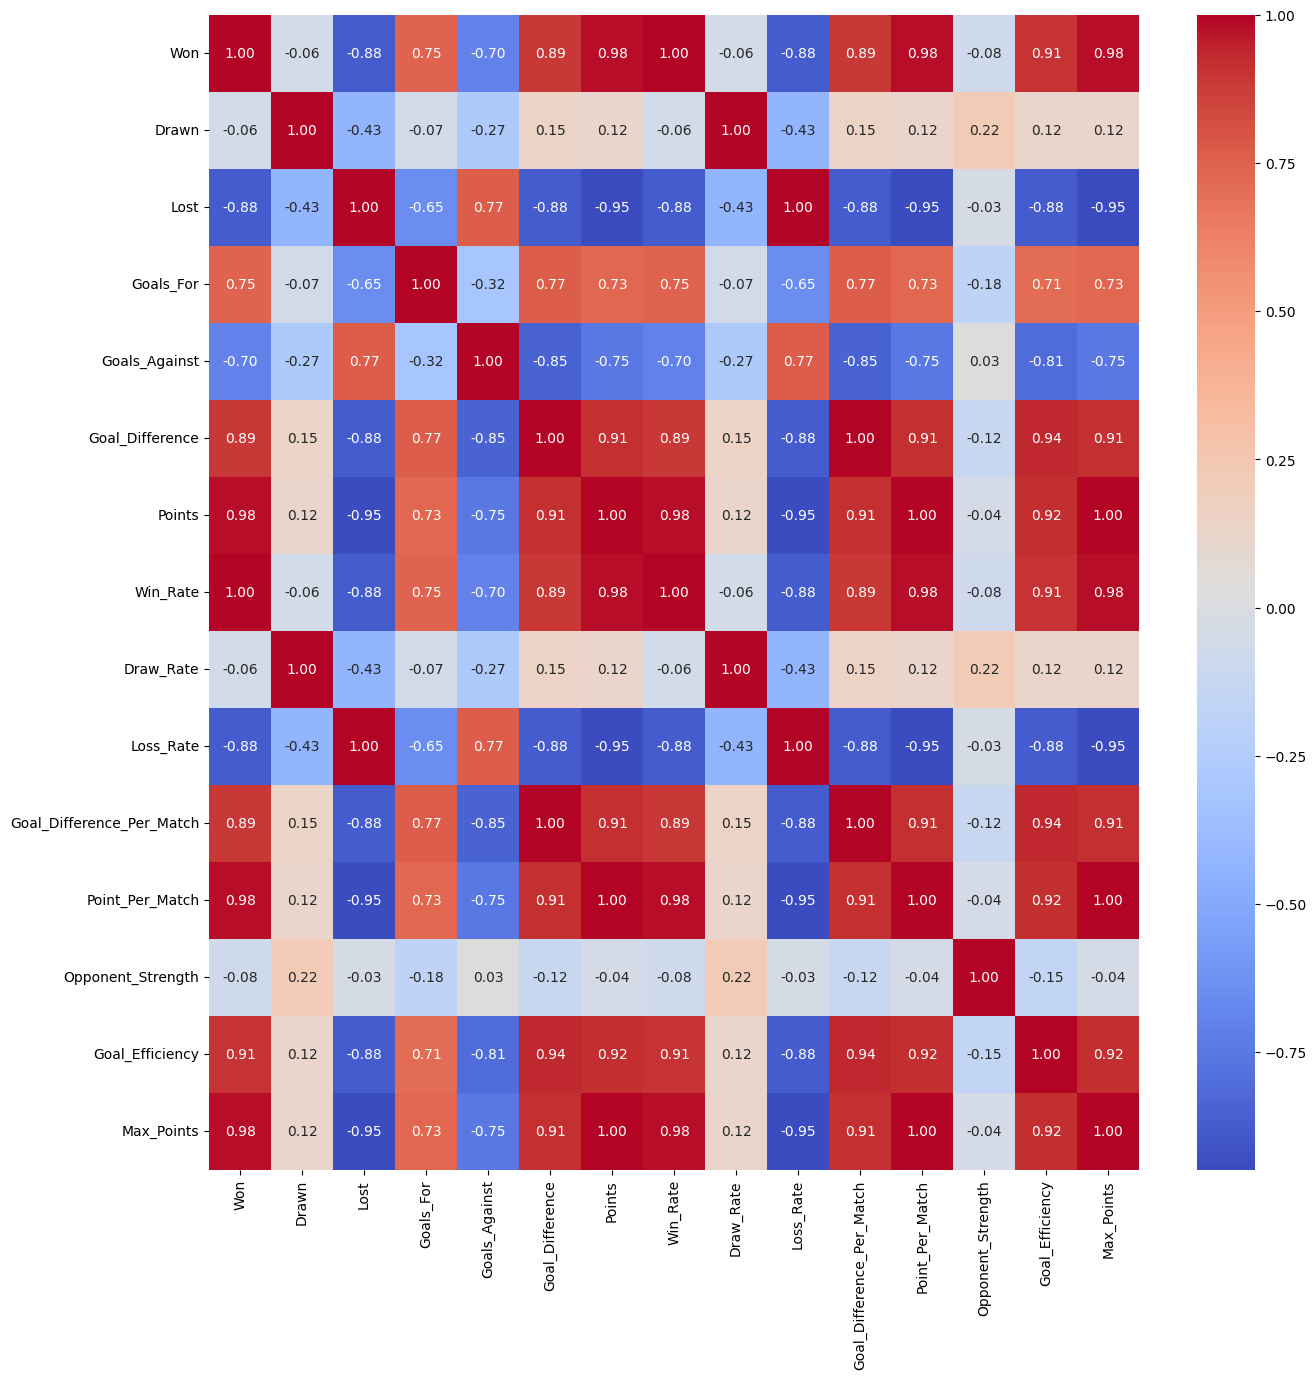

In [9]:
figsize, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr, cmap = 'coolwarm', annot = True, fmt = '.2f');

In [11]:
df.to_csv('teams_details.csv', index = False)

In [12]:
#df['Qualified'] = df['Position'].apply(lambda x: 1 if x <= 8 else 0)
df['Qualified'] = df['Points']/(matched_played * 3)

In [13]:
target = 'Qualified'
#X = df[['Team', 'Win_Rate', 'Draw_Rate', 'Loss_Rate', 'Goal_Difference_Per_Match', 'Point_Per_Match', 'Opponent_Strength', 'Goal_Efficiency', 'Max_Points', 'Qualified']]
X = df.drop(columns = [target])
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# grid = {'n_estimators': [10, 50, 100, 200],
#         'max_depth': [None, 10, 20, 30],
#         'min_samples_split': [2, 5, 10],
#         'min_samples_leaf': [1, 2, 4],
#         'bootstrap': [True, False]}
# model = make_pipeline(
#                     OneHotEncoder(use_cat_names=True),
#                     GridSearchCV(estimator=RandomForestRegressor(), cv = 5, n_jobs=-1, param_grid = grid)
# )
# model.fit(X_train, y_train)

In [14]:
grid = {'n_estimators': [5, 10, 20],
        'max_depth': [None, 1, 5, 10],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]}
model = make_pipeline(
                    OneHotEncoder(use_cat_names=True),
                    RandomForestRegressor(max_depth = 5, random_state = 42)#, cv = 5, n_jobs=-1, param_grid = grid)
)
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['Team', 'Opponent_1', 'Opponent_2'],
                               use_cat_names=True)),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=5, random_state=42))])

In [16]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")

MSE: 0.00
MAE: 0.03


In [17]:
prediction_df = pd.DataFrame(model.predict(X).tolist())
prediction_df = prediction_df.rename(columns = {0 : 'Probability'})
prediction_df['Teams'] = df['Team']
prediction_df.head()

,Probability,Teams
0,0.933889,Liverpool
1,0.798333,Barcelona
2,0.720556,Arsenal
3,0.720000,Bayer Leverkusen
4,0.721667,Aston Villa


In [18]:
import pickle as pkl
with open('ucl_model2.pkl', 'wb') as file: 
    pkl.dump(model, file)

,Probability,Teams
0,0.933889,Liverpool
1,0.798333,Barcelona
4,0.721667,Aston Villa
5,0.721667,Inter Milan
2,0.720556,Arsenal
3,0.720000,Bayer Leverkusen
6,0.720000,Brest
7,0.717778,Lille
9,0.673333,Bayern Munich
10,0.672222,Atletico Madrid
